# Vision Transformer

- paper : https://arxiv.org/pdf/2010.11929
- official code : https://github.com/google-research/vision_transformer






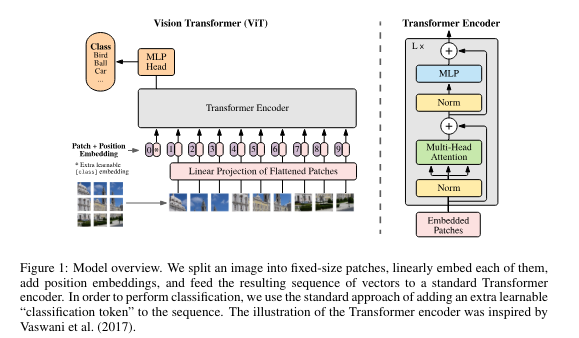

- Transformer tutorial : https://github.com/seonm9119/tutorials/blob/main/Transformer.ipynb
- BERT tutorial : https://github.com/seonm9119/tutorials/blob/main/BERT.ipynb




ViT(Vision Transformer)는 트랜스포머를 컴퓨터 비전에 처음 적용한 논문이다. 이 논문의 핵심 아이디어는 이미지를 패치 단위로 잘라 토큰으로 사용하는 것이다. 학습 방식이 BERT와 유사하며, 대용량 데이터로 모델을 사전 학습(pre-train)하여 다운스트림 태스크에서 사용하는 방식이다. 하지만, 마스크 토큰은 BERT의 가장 중요한 기여 요소 중 하나인, 마스크 토큰을 사용하지 않는다. 이후 마스크 토큰을 사용한 모델들이 등장한다. 모델 구조는 복잡하지 않으며, 구현 자체도 어렵지 않다.

## Inductive bias

논문의 서론에서 저자는 아래와 같이 서술한다.

> Transformers lack some of the inductive biases inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data.

즉, 데이터가 부족하면 ViT는 학습이 잘 안된다는 것인데, 왜 그럴까?

- CNN의 Inductive Bias
  - Local Connectivity: CNN은 각 뉴런이 인접한 일부 뉴런과만 연결되어 있어, 이미지의 작은 지역 패턴을 효과적으로 학습할 수 있다.
  - Spatial Invariance: CNN의 합성곱 연산은 동일한 필터를 이미지 전체에 적용하여, 패턴의 위치에 관계없이 동일하게 인식할 수 있도록 한다. 이는 이미지의 이동, 회전, 확대 등의 변환에 대해 강한 불변성을 부여한다.
 - Weight Sharing: 필터가 이미지 전체에 걸쳐 공유되므로, 학습해야 할 매개변수의 수가 줄어들어 모델이 더 효율적으로 학습된다.
 - Hierarchical Feature Learning: CNN은 저수준 특징(에지, 텍스처)부터 고수준 특징(객체의 일부, 전체 객체)까지 계층적으로 학습할 수 있다.

이러한 inductive bias는 CNN이 상대적으로 적은 데이터로도 좋은 성능을 발휘할 수 있게 해준다. 반면, Vision Transformer(ViT)는 이러한 강한 inductive bias가 없다. ViT는 이미지를 패치로 나누고, 각 패치를 하나의 토큰으로 처리하여 Attention을 통해 모든 패치 간의 관계를 학습하여 전역적인(Gloval) 이미지 패턴을 효과적으로 포착한다. 하지만, 이러한 전역적인 관계를 학습하는 과정에서 많은 데이터를 필요로 한다.

Vision Transformer vs CNN에 대한 비교 실험 및 차이에 대해 더 궁금하면 아래의 논문을 참조.
- paper : https://arxiv.org/pdf/2108.08810

# Let's GO!

### Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

#### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

#### Import packages

In [ ]:
!pip install einops

In [5]:
import torch
import torch.nn as nn

### Load Datasets

we will be working on the CIFAR-100, CIFAR-10 dataset, which has 60,000 training and 10,000 test images. we will use the PyTorch CIFAR-100, CIFAR-10 wrapper. See the [documentation](https://github.com/pytorch/vision/blob/main/torchvision/datasets/cifar.py) for more information about the interface.

In [3]:
from torch.utils.data import DataLoader

# custom packages
from data.cifar import CIFAR100, CIFAR10

In [ ]:
# for pre-train
train_dataset = CIFAR100(root='.', train=True, image_size=32)
test_dataset = CIFAR100(root='.', train=False, image_size=32)

pre_train = {}
pre_train['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
pre_train['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# for fine-tune
train_dataset = CIFAR10(root='.', train=True, image_size=32)
test_dataset = CIFAR10(root='.', train=False, image_size=32)

fine_tune = {}
fine_tune['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
fine_tune['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

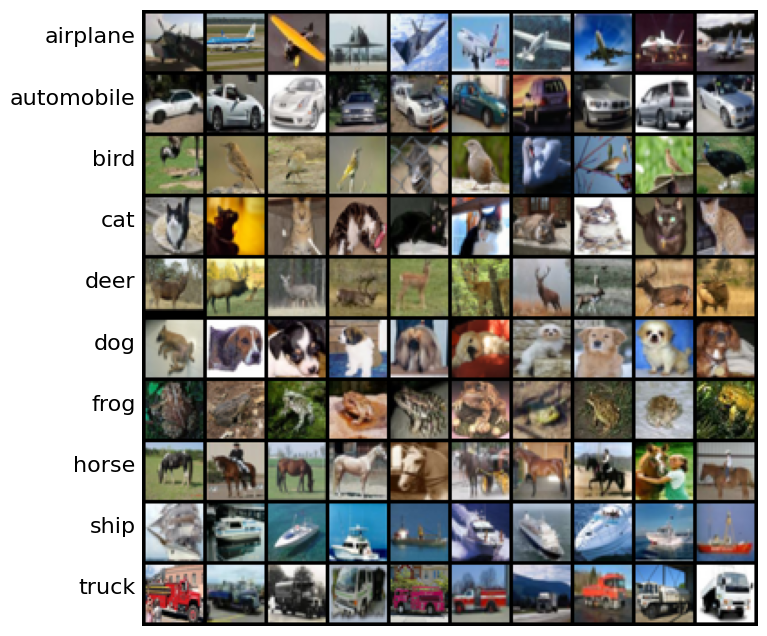

In [5]:
train_dataset.visualize_dataset(samples_per_class=10)

## Build a Vision Transformer

In [11]:
from einops.layers.torch import Rearrange

# custom packages
from models.transformer.transformer import EncoderLayer

In [12]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size=(3, 224, 224),
               dim_feedforward=3072,
               patch_size=16,
               num_classes=1000,
               d_model=768,
               n_layers=12,
               n_head=12,
               dropout=0.1):
      super().__init__()

      self.dropout = nn.Dropout(dropout)

      in_channels, H, W = img_size

      # patch embeding
      num_patches = H*W // patch_size ** 2
      patch_dim = in_channels * patch_size ** 2
      self.patch_embedding = nn.Sequential(
          nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size),
          Rearrange('b e (h) (w) -> b (h w) e')
          )

      # cls tokens
      self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

      # postion embed
      self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))

      _layers = [EncoderLayer(d_model, dim_feedforward, n_head, dropout) for _ in range(n_layers)]
      self.transformer = nn.Sequential(*_layers)

      self.mlp_head = nn.Linear(d_model, num_classes)

  def forward(self, x):

    x = self.patch_embedding(x)
    b, n, _ = x.shape

    cls_tokens = self.cls_token.expand(b, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n + 1)]

    patch_embed = self.dropout(x)
    output = self.transformer(patch_embed)[:,0]
    return self.mlp_head(output)

## Train a Net

위에서 구현한 모델은 논문의 핵심 개념을 이해하기 쉽도록 간단히 구현한 것이다. 스케줄러, 초기 가중치 설정 등의 세부 사항은 논문과 공식 코드를 참고하여 모델을 더 구체화하길 권장한다. 그럼 구현한 모델을 학습시켜 보자!

In [13]:
# custom packages
from colab_utils.vit import runner

일반적으로 사전 학습 단계에서는 대규모 데이터셋인 ImageNet을 사용한다. 하지만 우리는 간단한 테스트를 해보기위해 CIFAR-100을 사용하여 모델을 사전 학습시킨다.

In [16]:
pre_model = VisionTransformer(img_size=(3, 32, 32),
                              dim_feedforward=256,
                              patch_size=4,
                              num_classes=100,
                              d_model=128,
                              n_layers=6,
                              n_head=8,
                              dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pre_model.parameters(), lr=1e-3)

In [17]:
history = runner(pre_model, criterion, optimizer, pre_train, num_epochs=10, msg=2)
torch.save(pre_model.state_dict(), 'pre_train.pth')

Train using cuda
Epoch [2/10]          time: 0:01:10          train Loss: 3.2435          train ACC: 20.80%          val Loss: 3.1264          val ACC: 23.53%
Epoch [4/10]          time: 0:01:12          train Loss: 2.7674          train ACC: 29.77%          val Loss: 2.8230          val ACC: 29.30%
Epoch [6/10]          time: 0:01:14          train Loss: 2.4979          train ACC: 35.14%          val Loss: 2.6979          val ACC: 31.66%
Epoch [8/10]          time: 0:01:08          train Loss: 2.2724          train ACC: 39.75%          val Loss: 2.6245          val ACC: 34.18%
Epoch [10/10]          time: 0:01:07          train Loss: 2.0903          train ACC: 43.92%          val Loss: 2.5546          val ACC: 35.58%

Finished Training
Toral Training Time: 0:05:54
Accuracy of the test images: 36.06%


학습된 모델을 활용하여 다운스트림 태스크로 CIFAR-10의 Classification을 수행해보자!

In [18]:
fine_model = VisionTransformer(img_size=(3, 32, 32),
                               dim_feedforward=256,
                               patch_size=4,
                               num_classes=10,
                               d_model=128,
                               n_layers=6,
                               n_head=8,
                               dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_model.parameters(), lr=1e-3)

In [19]:
checkpoint = torch.load("pre_train.pth")
checkpoint = {key: val for key, val in checkpoint.items() if 'mlp_head' not in key}
fine_model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['mlp_head.weight', 'mlp_head.bias'], unexpected_keys=[])

In [20]:
history = runner(fine_model, criterion, optimizer, fine_tune, num_epochs=5, msg=1)
torch.save(fine_model.state_dict(), 'fine_tune.pth')

Train using cuda
Epoch [1/5]          time: 0:00:35          train Loss: 1.2147          train ACC: 56.01%          val Loss: 1.1036          val ACC: 60.03%
Epoch [2/5]          time: 0:00:34          train Loss: 1.0075          train ACC: 63.90%          val Loss: 1.0218          val ACC: 63.14%
Epoch [3/5]          time: 0:00:34          train Loss: 0.9246          train ACC: 67.01%          val Loss: 1.0147          val ACC: 63.60%
Epoch [4/5]          time: 0:00:32          train Loss: 0.8608          train ACC: 69.39%          val Loss: 0.9770          val ACC: 65.00%
Epoch [5/5]          time: 0:00:32          train Loss: 0.8185          train ACC: 70.98%          val Loss: 1.0067          val ACC: 64.69%

Finished Training
Toral Training Time: 0:02:48
Accuracy of the test images: 64.64%
